In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import time
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb
from tqdm import tqdm

#### Output file

In [2]:
sourceFile = open("gpu_logs/coopernico_672.txt", 'w')

### Load the data

In [3]:
df = pd.read_csv("data/coopernico_50houses_location.csv")
## Leaving the first house (public building out) due to its different profile
df = df.iloc[:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
num_samples_per_house = df.Location.value_counts()[1]
df.reset_index(drop=True, inplace=True)
df

,Time,Location,Energy
0,2021-11-01 00:15:00,PT84ZD,0.144
1,2021-11-01 00:30:00,PT84ZD,0.144
2,2021-11-01 00:45:00,PT84ZD,0.144
3,2021-11-01 01:00:00,PT84ZD,0.144
4,2021-11-01 01:15:00,PT84ZD,0.028
...,...,...,...
1138131,2023-02-28 23:00:00,PT37FP,0.000
1138132,2023-02-28 23:15:00,PT37FP,1.000
1138133,2023-02-28 23:30:00,PT37FP,0.000
1138134,2023-02-28 23:45:00,PT37FP,1.000


In [4]:
#trunc = lambda x: math.trunc(10000 * x) / 10000
#df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
#df = pd.concat([df.iloc[:, 0:-1], df_trunc], axis=1)
#df

### Auxiliary functions

In [5]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [6]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)

def past_timesteps(df, number_of_timesteps):
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values(by=['Location', 'Time'])
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

#def past_timesteps(df, number_of_timesteps):
#    # Sort the dataframe by location and time
#    df = df.sort_values(by=['Location', 'Time'])
#
#    # Compute rolling window over time axis to extract past energy values for each location
#    energy_lags = [f"energy_lag_{i}" for i in range(1, number_of_timesteps+1)]
#    past_energy = df.groupby('Location')['Energy'].rolling(window=number_of_timesteps, min_periods=1).apply(np.mean())
#    # Add new columns to the dataframe for each past energy value
#    for i, energy_lag in enumerate(energy_lags):
#        df[energy_lag] = past_energy.apply(lambda x: x[-i-1] if isinstance(x, list) and len(x)>=i+1 else x)
#
#    # Drop rows with missing values
#    df.dropna(inplace=True)
#    df.reset_index(drop=True, inplace=True)
#
#    return df


def last_energy_points_full(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    other_feats = df.iloc[:,:2]
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = df.copy().iloc[:,2]
    y.iloc[:number_timesteps] = np.nan
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X = pd.concat([other_feats, X], axis=1)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    dataframe = pd.concat([X,y.rename('Energy')], axis=1)
    assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
    return dataframe
    

In [7]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [8]:
def test_leave_house_out(df, estimator, locations, filename):
    test = df[df['Location'].isin(locations)]
    train = df[~df['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']
    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)
    #y_train_norm, scaler2 = normalize_training(y_train)
    #y_test_norm = scaler2.transform(y_test)
    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Save Dataframe with past timesteps

In [9]:
number_of_timesteps = 672

In [10]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

 14%|█▍        | 95/672 [00:01<00:09, 58.62it/s]/tmp/ipykernel_3666346/1399399553.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
/tmp/ipykernel_3666346/1399399553.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
/tmp/ipykernel_3666346/1399399553.py:11: PerformanceWarning: DataFrame is highly fragm

,Time,Location,Energy,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,...,energy_lag_663,energy_lag_664,energy_lag_665,energy_lag_666,energy_lag_667,energy_lag_668,energy_lag_669,energy_lag_670,energy_lag_671,energy_lag_672
0,2021-11-08 00:15:00,PT01NZ,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,...,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000
1,2021-11-08 00:30:00,PT01NZ,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,...,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000
2,2021-11-08 00:45:00,PT01NZ,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,...,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000
3,2021-11-08 01:00:00,PT01NZ,1.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,...,1.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000
4,2021-11-08 01:15:00,PT01NZ,1.000,1.000,1.000,0.000,1.000,0.000,1.000,0.000,...,0.000,1.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038679,2022-10-31 23:00:00,PT92QP,0.020,0.016,0.020,0.020,0.020,0.020,0.016,0.020,...,0.016,0.020,0.020,0.020,0.016,0.020,0.020,0.020,0.016,0.020
1038680,2022-10-31 23:15:00,PT92QP,0.020,0.020,0.016,0.020,0.020,0.020,0.020,0.016,...,0.020,0.016,0.020,0.020,0.020,0.016,0.020,0.020,0.020,0.016
1038681,2022-10-31 23:30:00,PT92QP,0.020,0.020,0.020,0.016,0.020,0.020,0.020,0.020,...,0.020,0.020,0.016,0.020,0.020,0.020,0.016,0.020,0.020,0.020
1038682,2022-10-31 23:45:00,PT92QP,0.016,0.020,0.020,0.020,0.016,0.020,0.020,0.020,...,0.020,0.020,0.020,0.016,0.020,0.020,0.020,0.016,0.020,0.020


In [11]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

,Time,Location,Energy,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,...,energy_lag_666,energy_lag_667,energy_lag_668,energy_lag_669,energy_lag_670,energy_lag_671,energy_lag_672,DayOfWeek,Weekend,Hour
0,2021-11-08 00:15:00,PT01NZ,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,...,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0,0,0
1,2021-11-08 00:30:00,PT01NZ,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,...,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0,0,0
2,2021-11-08 00:45:00,PT01NZ,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,...,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0,0,0
3,2021-11-08 01:00:00,PT01NZ,1.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,...,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0,0,1
4,2021-11-08 01:15:00,PT01NZ,1.000,1.000,1.000,0.000,1.000,0.000,1.000,0.000,...,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038679,2022-10-31 23:00:00,PT92QP,0.020,0.016,0.020,0.020,0.020,0.020,0.016,0.020,...,0.020,0.016,0.020,0.020,0.020,0.016,0.020,0,0,23
1038680,2022-10-31 23:15:00,PT92QP,0.020,0.020,0.016,0.020,0.020,0.020,0.020,0.016,...,0.020,0.020,0.016,0.020,0.020,0.020,0.016,0,0,23
1038681,2022-10-31 23:30:00,PT92QP,0.020,0.020,0.020,0.016,0.020,0.020,0.020,0.020,...,0.020,0.020,0.020,0.016,0.020,0.020,0.020,0,0,23
1038682,2022-10-31 23:45:00,PT92QP,0.016,0.020,0.020,0.020,0.016,0.020,0.020,0.020,...,0.016,0.020,0.020,0.020,0.016,0.020,0.020,0,0,23


In [ ]:
df_new.to_csv("data/coopernico_oneweek.csv", index=False)

## Predict  10 folds with 10 random houses for test

In [12]:
df_test = pd.read_csv("data/coopernico_oneweek.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df = pd.read_csv("data/coopernico_oneweek.csv", engine='c', dtype=float32_cols)
df

,Time,Location,Energy,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,...,energy_lag_666,energy_lag_667,energy_lag_668,energy_lag_669,energy_lag_670,energy_lag_671,energy_lag_672,DayOfWeek,Weekend,Hour
0,2021-11-08 00:15:00,PT01NZ,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,...,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0,0,0
1,2021-11-08 00:30:00,PT01NZ,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,...,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0,0,0
2,2021-11-08 00:45:00,PT01NZ,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,...,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0,0,0
3,2021-11-08 01:00:00,PT01NZ,1.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,...,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0,0,1
4,2021-11-08 01:15:00,PT01NZ,1.000,1.000,1.000,0.000,1.000,0.000,1.000,0.000,...,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038679,2022-10-31 23:00:00,PT92QP,0.020,0.016,0.020,0.020,0.020,0.020,0.016,0.020,...,0.020,0.016,0.020,0.020,0.020,0.016,0.020,0,0,23
1038680,2022-10-31 23:15:00,PT92QP,0.020,0.020,0.016,0.020,0.020,0.020,0.020,0.016,...,0.020,0.020,0.016,0.020,0.020,0.020,0.016,0,0,23
1038681,2022-10-31 23:30:00,PT92QP,0.020,0.020,0.020,0.016,0.020,0.020,0.020,0.020,...,0.020,0.020,0.020,0.016,0.020,0.020,0.020,0,0,23
1038682,2022-10-31 23:45:00,PT92QP,0.016,0.020,0.020,0.020,0.016,0.020,0.020,0.020,...,0.016,0.020,0.020,0.020,0.016,0.020,0.020,0,0,23


In [13]:
df.isna().sum().sum()

0

In [14]:
num_houses_test = 10

In [15]:
locations = []
for i in range(10):
    np.random.seed(i*4)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array(['PT61DK', 'PT31GJ', 'PT28AS', 'PT75MV', 'PT16CG', 'PT58SX',
        'PT73RB', 'PT64BZ', 'PT51YP', 'PT24EC'], dtype=object),
 array(['PT25VW', 'PT92KV', 'PT31GJ', 'PT24EC', 'PT33DY', 'PT64BZ',
        'PT26AT', 'PT58FW', 'PT75MV', 'PT43EA'], dtype=object),
 array(['PT84ZD', 'PT92QP', 'PT72LM', 'PT53VD', 'PT92KV', 'PT51YP',
        'PT65SJ', 'PT01NZ', 'PT43AE', 'PT86XC'], dtype=object),
 array(['PT61DK', 'PT87CQ', 'PT26AT', 'PT75MV', 'PT72LM', 'PT61WB',
        'PT47FA', 'PT92KV', 'PT44HY', 'PT26CA'], dtype=object),
 array(['PT22FE', 'PT66PT', 'PT58FW', 'PT72LM', 'PT46LV', 'PT53VD',
        'PT67FS', 'PT47FA', 'PT74TE', 'PT74PR'], dtype=object),
 array(['PT33DY', 'PT37FP', 'PT24EC', 'PT26CA', 'PT86XC', 'PT14YZ',
        'PT58FW', 'PT54MR', 'PT91LB', 'PT53VD'], dtype=object),
 array(['PT26CA', 'PT24FF', 'PT64MJ', 'PT58JM', 'PT44HY', 'PT16CG',
        'PT42TA', 'PT74TE', 'PT61WB', 'PT72VJ'], dtype=object),
 array(['PT31GJ', 'PT42TA', 'PT26MC', 'PT64BZ', 'PT58SX', 'PT46LV',
        

### Linear Regression

In [16]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

Train set:  (859192, 678)
Test set:  (179492, 678)
Train set:  (849278, 678)
Test set:  (189406, 678)
Train set:  (780558, 678)
Test set:  (258126, 678)
Train set:  (852726, 678)
Test set:  (185958, 678)
Train set:  (825123, 678)
Test set:  (213561, 678)


### XGBoost

In [17]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

Train set:  (859192, 678)
Test set:  (179492, 678)
Train set:  (849278, 678)
Test set:  (189406, 678)
Train set:  (780558, 678)
Test set:  (258126, 678)
Train set:  (852726, 678)
Test set:  (185958, 678)
Train set:  (825123, 678)
Test set:  (213561, 678)


### Random Forest

In [ ]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

## Averaged Metrics

In [18]:
print("\n\n\n", file=sourceFile)

In [19]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [20]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [ ]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

In [21]:
sourceFile.close()

### Feature Importance

In [22]:
print('Linear Regression\n')
for i,v in enumerate(model_lr.coef_):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

Linear Regression

Feature: 0, Score: 130.04933
Feature: 1, Score: -34.87797
Feature: 2, Score: 9.26465
Feature: 3, Score: -8.16146
Feature: 4, Score: 0.40727
Feature: 5, Score: -4.20889
Feature: 6, Score: -2.88197
Feature: 7, Score: -0.77745
Feature: 8, Score: -1.32426
Feature: 9, Score: 0.93522
Feature: 10, Score: -0.73901
Feature: 11, Score: 1.27255
Feature: 12, Score: -0.25238
Feature: 13, Score: 0.90941
Feature: 14, Score: 0.91255
Feature: 15, Score: 0.28222
Feature: 16, Score: 0.10680
Feature: 17, Score: 0.81267
Feature: 18, Score: 0.05113
Feature: 19, Score: 0.82692
Feature: 20, Score: 2.10039
Feature: 21, Score: -0.48924
Feature: 22, Score: 0.14975
Feature: 23, Score: 0.37287
Feature: 24, Score: 0.55579
Feature: 25, Score: 0.99725
Feature: 26, Score: -0.44642
Feature: 27, Score: -0.09374
Feature: 28, Score: 1.05286
Feature: 29, Score: 0.10473
Feature: 30, Score: 1.43667
Feature: 31, Score: -0.79464
Feature: 32, Score: 0.71080
Feature: 33, Score: -0.77791
Feature: 34, Score: 0.7

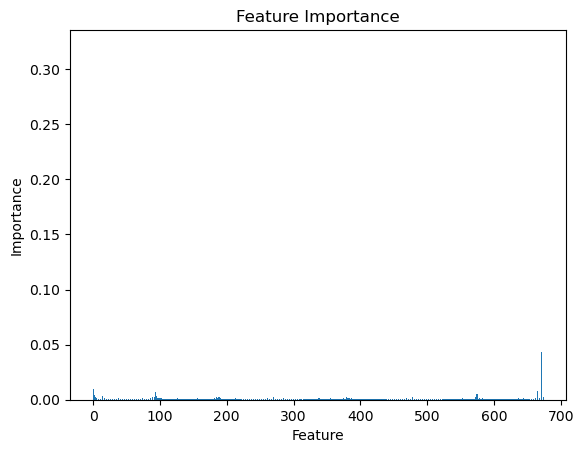

In [23]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

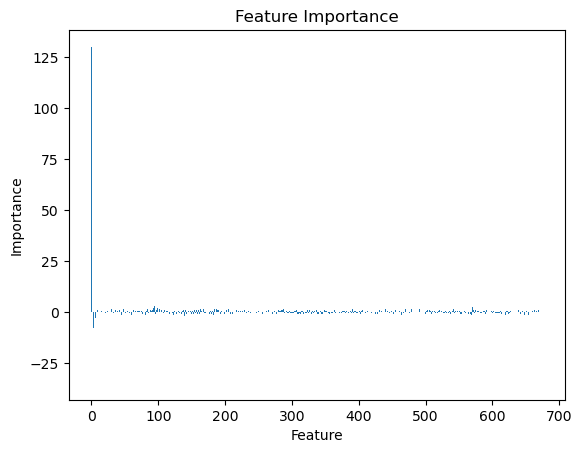

In [24]:
plt.bar(range(len(model_lr.coef_)),model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [25]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

energy_lag_1      0.319566
energy_lag_2      0.009685
energy_lag_3      0.003928
energy_lag_4      0.002008
energy_lag_5      0.002901
                    ...   
energy_lag_671    0.028021
energy_lag_672    0.043414
DayOfWeek         0.000553
Weekend           0.000000
Hour              0.002195
Length: 675, dtype: float32

In [26]:
features = feature_importance.nlargest(20).index
features

Index(['energy_lag_1', 'energy_lag_672', 'energy_lag_167', 'energy_lag_671',
       'energy_lag_2', 'energy_lag_228', 'energy_lag_666', 'energy_lag_94',
       'energy_lag_95', 'energy_lag_445', 'energy_lag_11', 'energy_lag_191',
       'energy_lag_667', 'energy_lag_575', 'energy_lag_576', 'energy_lag_3',
       'energy_lag_92', 'energy_lag_665', 'energy_lag_10', 'energy_lag_348'],
      dtype='object')

In [27]:
df_20 = df[['Time', 'Location'] + [*features] + ['Energy']]
df_20

,Time,Location,energy_lag_1,energy_lag_672,energy_lag_167,energy_lag_671,energy_lag_2,energy_lag_228,energy_lag_666,energy_lag_94,...,energy_lag_191,energy_lag_667,energy_lag_575,energy_lag_576,energy_lag_3,energy_lag_92,energy_lag_665,energy_lag_10,energy_lag_348,Energy
0,2021-11-08 00:15:00,PT01NZ,0.000,1.000,1.000,0.000,1.000,2.000,0.000,1.000,...,1.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000,2.000,1.000
1,2021-11-08 00:30:00,PT01NZ,1.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,...,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,2.000,0.000
2,2021-11-08 00:45:00,PT01NZ,0.000,1.000,0.000,0.000,1.000,2.000,0.000,1.000,...,1.000,1.000,1.000,0.000,0.000,0.000,1.000,2.000,1.000,1.000
3,2021-11-08 01:00:00,PT01NZ,1.000,0.000,0.000,1.000,0.000,3.000,1.000,0.000,...,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000
4,2021-11-08 01:15:00,PT01NZ,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,...,1.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,2.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038679,2022-10-31 23:00:00,PT92QP,0.016,0.020,0.016,0.016,0.020,0.020,0.020,0.020,...,0.020,0.016,0.016,0.020,0.020,0.016,0.020,0.020,0.072,0.020
1038680,2022-10-31 23:15:00,PT92QP,0.020,0.016,0.020,0.020,0.016,0.020,0.020,0.020,...,0.020,0.020,0.020,0.016,0.020,0.020,0.020,0.016,0.080,0.020
1038681,2022-10-31 23:30:00,PT92QP,0.020,0.020,0.020,0.020,0.020,0.016,0.020,0.016,...,0.020,0.020,0.020,0.020,0.016,0.020,0.016,0.020,0.076,0.020
1038682,2022-10-31 23:45:00,PT92QP,0.020,0.020,0.020,0.020,0.020,0.020,0.016,0.020,...,0.016,0.020,0.020,0.020,0.020,0.020,0.020,0.020,0.020,0.016


In [28]:
df_20.to_csv("data/coopernico_best20features.csv", index=False)

### Test with 20 best features

In [29]:
df_20 = pd.read_csv("data/coopernico_best20features.csv")
df_20

,Time,Location,energy_lag_1,energy_lag_672,energy_lag_167,energy_lag_671,energy_lag_2,energy_lag_228,energy_lag_666,energy_lag_94,...,energy_lag_191,energy_lag_667,energy_lag_575,energy_lag_576,energy_lag_3,energy_lag_92,energy_lag_665,energy_lag_10,energy_lag_348,Energy
0,2021-11-08 00:15:00,PT01NZ,0.000,1.000,1.000,0.000,1.000,2.000,0.000,1.000,...,1.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000,2.000,1.000
1,2021-11-08 00:30:00,PT01NZ,1.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,...,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,2.000,0.000
2,2021-11-08 00:45:00,PT01NZ,0.000,1.000,0.000,0.000,1.000,2.000,0.000,1.000,...,1.000,1.000,1.000,0.000,0.000,0.000,1.000,2.000,1.000,1.000
3,2021-11-08 01:00:00,PT01NZ,1.000,0.000,0.000,1.000,0.000,3.000,1.000,0.000,...,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000
4,2021-11-08 01:15:00,PT01NZ,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,...,1.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,2.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038679,2022-10-31 23:00:00,PT92QP,0.016,0.020,0.016,0.016,0.020,0.020,0.020,0.020,...,0.020,0.016,0.016,0.020,0.020,0.016,0.020,0.020,0.072,0.020
1038680,2022-10-31 23:15:00,PT92QP,0.020,0.016,0.020,0.020,0.016,0.020,0.020,0.020,...,0.020,0.020,0.020,0.016,0.020,0.020,0.020,0.016,0.080,0.020
1038681,2022-10-31 23:30:00,PT92QP,0.020,0.020,0.020,0.020,0.020,0.016,0.020,0.016,...,0.020,0.020,0.020,0.020,0.016,0.020,0.016,0.020,0.076,0.020
1038682,2022-10-31 23:45:00,PT92QP,0.020,0.020,0.020,0.020,0.020,0.020,0.016,0.020,...,0.016,0.020,0.020,0.020,0.020,0.020,0.020,0.020,0.020,0.016


In [30]:
sourceFile = open("gpu_logs/coopernico_20best.txt", 'w')

In [31]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_lr = test_leave_house_out(df_20, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

Train set:  (859192, 23)
Test set:  (179492, 23)
Train set:  (849278, 23)
Test set:  (189406, 23)
Train set:  (780558, 23)
Test set:  (258126, 23)
Train set:  (852726, 23)
Test set:  (185958, 23)
Train set:  (825123, 23)
Test set:  (213561, 23)


In [32]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_xgb = test_leave_house_out(df_20, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

Train set:  (859192, 23)
Test set:  (179492, 23)
Train set:  (849278, 23)
Test set:  (189406, 23)
Train set:  (780558, 23)
Test set:  (258126, 23)
Train set:  (852726, 23)
Test set:  (185958, 23)
Train set:  (825123, 23)
Test set:  (213561, 23)


In [34]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_rf = test_leave_house_out(df_20, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

Train set:  (859192, 23)
Test set:  (179492, 23)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (849278, 23)
Test set:  (189406, 23)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (780558, 23)
Test set:  (258126, 23)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (852726, 23)
Test set:  (185958, 23)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (825123, 23)
Test set:  (213561, 23)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [35]:
print("\n\n\n", file=sourceFile)

In [36]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [37]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [38]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

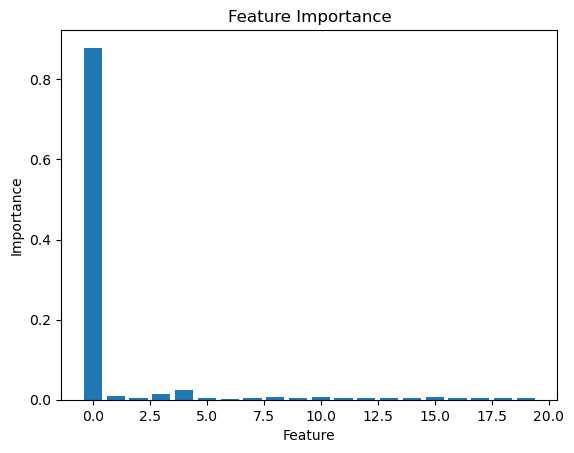

In [39]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [40]:
sourceFile.close()